#Import Library

In [79]:
import nltk
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pastikan untuk mengunduh semua data NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#Data Loading

In [80]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Data Cleaning

In [82]:
sentiment = df['sentiment'].value_counts()
print("Jumlah data per sentiment review:", sentiment)

Jumlah data per sentiment review: sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [83]:
missing_values = df.isnull().sum()
print("Jumlah missing values per kolom:")
print(missing_values)

Jumlah missing values per kolom:
review       0
sentiment    0
dtype: int64


In [84]:
duplicate_rows = df.duplicated()
print("Jumlah duplikasi data:", duplicate_rows.sum())

Jumlah duplikasi data: 418


In [85]:
print("Baris duplikat:")
print(df[duplicate_rows])

Baris duplikat:
                                                  review sentiment
3537   Quite what the producers of this appalling ada...  negative
3769   My favourite police series of all time turns t...  positive
4391   Beautiful film, pure Cassavetes style. Gena Ro...  positive
6352   If you liked the Grinch movie... go watch that...  negative
6479   I want very much to believe that the above quo...  negative
...                                                  ...       ...
49912  This is an incredible piece of drama and power...  positive
49950  This was a very brief episode that appeared in...  negative
49984  Hello it is I Derrick Cannon and I welcome you...  negative
49986  This movie is a disgrace to the Major League F...  negative
49991  Les Visiteurs, the first movie about the medie...  negative

[418 rows x 2 columns]


In [86]:
df = df.drop_duplicates()

In [87]:
df.reset_index(drop=True, inplace=True)

In [88]:
sentiment = df['sentiment'].value_counts()
print("Jumlah data per sentiment sentiment:", sentiment)

Jumlah data per sentiment sentiment: sentiment
positive    24884
negative    24698
Name: count, dtype: int64


In [89]:
df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10316\1137712857.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)


In [90]:
print(df)

                                                  review  sentiment
0      One of the other reviewers has mentioned that ...          1
1      A wonderful little production. <br /><br />The...          1
2      I thought this was a wonderful way to spend ti...          1
3      Basically there's a family where a little boy ...          0
4      Petter Mattei's "Love in the Time of Money" is...          1
...                                                  ...        ...
49577  I thought this movie did a down right good job...          1
49578  Bad plot, bad dialogue, bad acting, idiotic di...          0
49579  I am a Catholic taught in parochial elementary...          0
49580  I'm going to have to disagree with the previou...          0
49581  No one expects the Star Trek movies to be high...          0

[49582 rows x 2 columns]


# Exploratory Data Analysis

In [91]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


**Penghapusan karakter br/**

In [92]:
import re

def remove_br_tags(text):
    pattern = re.compile(r'<br\s*/?>')
    return pattern.sub('', text)

df['review'] = df['review'].apply(remove_br_tags)

In [93]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


<Axes: xlabel='count', ylabel='sentiment'>

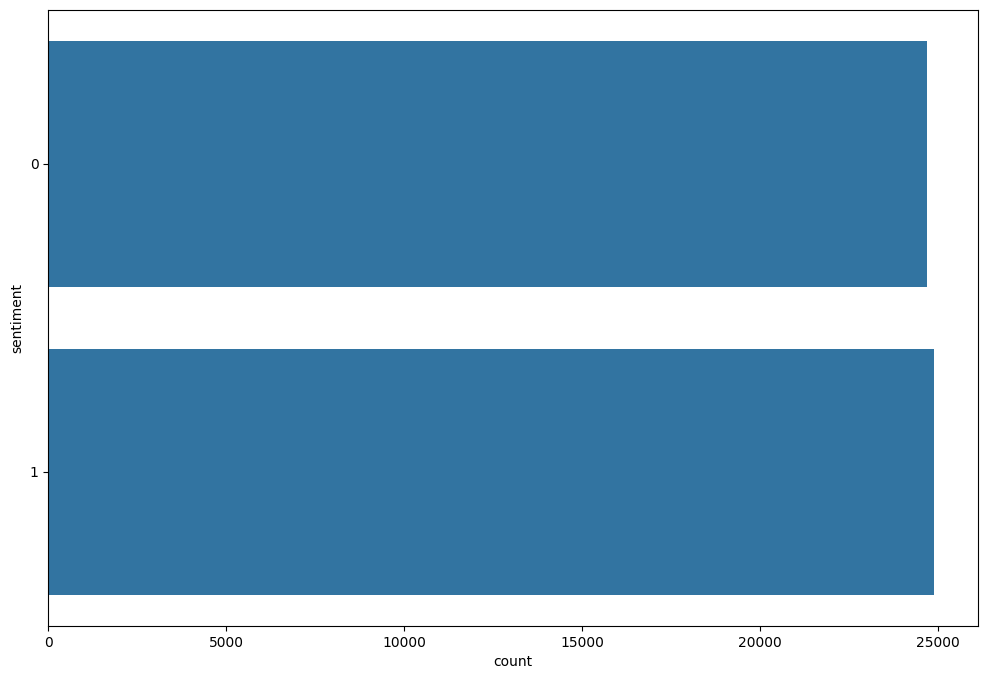

In [94]:
plt.figure(figsize=(12,8))
sns.countplot(y = 'sentiment', data=df)

(-0.5, 799.5, 799.5, -0.5)

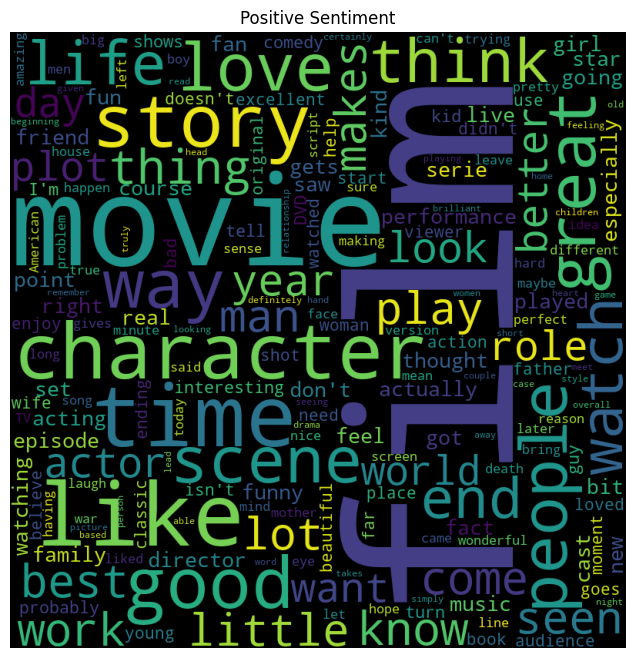

In [95]:
stopwords = set(STOPWORDS)
sentences=df['review']

pos=' '.join(map(str,sentences[df['sentiment']==1]))
neg=' '.join(map(str,sentences[df['sentiment']==0]))

wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(pos)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Positive Sentiment')
plt.axis('off')

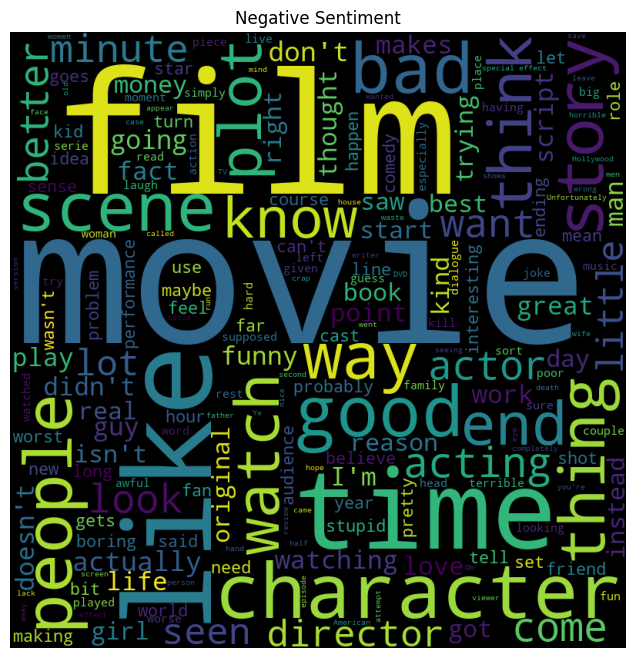

In [96]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(neg)

plt.imshow(wordcloud2)
plt.title('Negative Sentiment')
plt.axis('off')

plt.show()

In [97]:
word_counts = df['review'].apply(lambda x: len(str(x).split()))

In [98]:
word_counts.head()

0    301
1    156
2    162
3    132
4    222
Name: review, dtype: int64

In [99]:
max_words = df['review'].str.split().str.len().max()
print(f'Maximum kata pada kolom review: {max_words}')

Maximum kata pada kolom review: 2450


# Pre Processing Data

In [100]:
review = ' '.join(df['review'].tolist())

**Penghapusan Spesial Karakter**

In [101]:
def remove_special_characters(review):
    # Regular expression untuk karakter khusus
    pattern = r'[^a-zA-Z0-9\s]'
    cleaned_review = re.sub(pattern, '', review)
    return cleaned_review

In [102]:
df['review'] = df['review'].apply(remove_special_characters)

**Konversi kata ke huruf kecil**

In [103]:
df['review'] = df['review'].str.lower()

In [104]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


**Penghapusan Stopwords**

In [105]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('indonesian')
stop_words.extend(['yang','untuk','ke','pada','dan'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
      result.append(token)

  return result

In [107]:
df['clean'] = df['review'].apply(preprocess)

In [108]:
df['clean'] = df['clean'].apply(lambda x: " ".join(x))
df.head()

,review,sentiment,clean
0,one of the other reviewers has mentioned that ...,1,reviewers mentioned watching episode youll hoo...
1,a wonderful little production the filming tech...,1,wonderful little production filming technique ...
2,i thought this was a wonderful way to spend ti...,1,thought wonderful spend time summer weekend si...
3,basically theres a family where a little boy j...,0,basically theres family little jake thinks the...
4,petter matteis love in the time of money is a ...,1,petter matteis love time money visually stunni...


**Stemming**

In [109]:
nltk.download('punkt')
porter = PorterStemmer()

def stem_text(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [porter.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# Terapkan fungsi ke kolom 'clean'
df['stemmed_text'] = df['clean'].apply(stem_text)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,review,sentiment,clean,stemmed_text
0,one of the other reviewers has mentioned that ...,1,reviewers mentioned watching episode youll hoo...,review mention watch episod youll hook right e...
1,a wonderful little production the filming tech...,1,wonderful little production filming technique ...,wonder littl product film techniqu unassum old...
2,i thought this was a wonderful way to spend ti...,1,thought wonderful spend time summer weekend si...,thought wonder spend time summer weekend sit c...
3,basically theres a family where a little boy j...,0,basically theres family little jake thinks the...,basic there famili littl jake think there zomb...
4,petter matteis love in the time of money is a ...,1,petter matteis love time money visually stunni...,petter mattei love time money visual stun film...


**Lemmatization**

In [110]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df['lemmatized_text'] = df['clean'].apply(lemmatize_text)
df.head()

,review,sentiment,clean,stemmed_text,lemmatized_text
0,one of the other reviewers has mentioned that ...,1,reviewers mentioned watching episode youll hoo...,review mention watch episod youll hook right e...,reviewer mentioned watching episode youll hook...
1,a wonderful little production the filming tech...,1,wonderful little production filming technique ...,wonder littl product film techniqu unassum old...,wonderful little production filming technique ...
2,i thought this was a wonderful way to spend ti...,1,thought wonderful spend time summer weekend si...,thought wonder spend time summer weekend sit c...,thought wonderful spend time summer weekend si...
3,basically theres a family where a little boy j...,0,basically theres family little jake thinks the...,basic there famili littl jake think there zomb...,basically there family little jake think there...
4,petter matteis love in the time of money is a ...,1,petter matteis love time money visually stunni...,petter mattei love time money visual stun film...,petter matteis love time money visually stunni...


In [111]:
# split data into training data and test data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [112]:
print(train_data.shape)
print(test_data.shape)

(39665, 5)
(9917, 5)


In [113]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [114]:
print(X_train)

[[   0    0    0 ...  363  205  133]
 [   0    0    0 ... 4247    2 2754]
 [ 145  185    1 ...  387   24  192]
 ...
 [1620    4   86 ...    8    3 3378]
 [   0    0    0 ...  241  102  121]
 [   0    0    0 ...    4    1 2742]]


In [115]:
print(X_test)

[[   0    0    0 ...    3   38   38]
 [3328    4    3 ...   36    9   27]
 [  69   21   67 ...    1   39    1]
 ...
 [  30   24    1 ...    8   65 1038]
 [   0    0    0 ...    1  308  310]
 [   0    0    0 ...   82   13  643]]


In [116]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [117]:
print(Y_train)

7827     0
4811     0
35252    1
3446     0
24377    0
        ..
11284    0
44732    0
38158    0
860      1
15795    1
Name: sentiment, Length: 39665, dtype: int64


# Build Model

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Definisikan model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200)) # input_length ditambahkan untuk memastikan input shape
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

# Build the model with the specified input shape
model.build(input_shape=(None, 200))  # (batch_size, timesteps)

# Tampilkan summary dari model
model.summary()

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

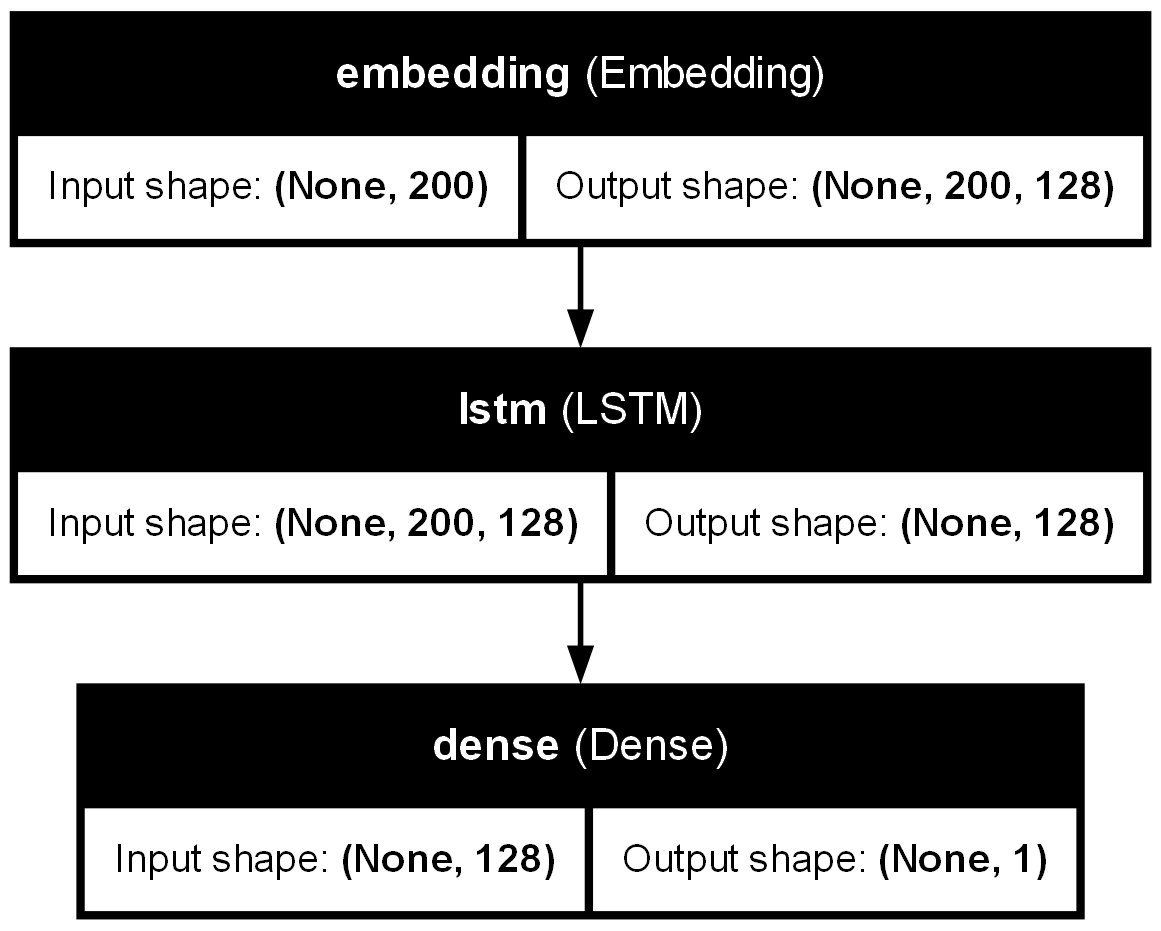

In [120]:
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
from IPython.display import Image

# Simpan diagram arsitektur model dalam bentuk file gambar
plot_model(model, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)

# Tampilkan gambar diagram model
Image(filename='model_lstm.png')

In [123]:
model.fit(X_train, Y_train, epochs=20, batch_size=1024, validation_split=0.3)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8866 - loss: 0.2873 - val_accuracy: 0.8290 - val_loss: 0.3907
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8809 - loss: 0.2973 - val_accuracy: 0.8545 - val_loss: 0.3455
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8916 - loss: 0.2810 - val_accuracy: 0.8608 - val_loss: 0.3378
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9034 - loss: 0.2479 - val_accuracy: 0.8666 - val_loss: 0.3380
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9089 - loss: 0.2414 - val_accuracy: 0.8636 - val_loss: 0.3453
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9110 - loss: 0.2321 - val_accuracy: 0.8516 - val_loss: 0.3567
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9079 - loss: 0.2391 - val_accuracy: 0.8671 - val_loss: 0.3529
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 973ms/step - accuracy: 0.9128 - loss: 0.2260 - val_accuracy: 0.8603 - val_lo

In [124]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8638 - loss: 0.4123
Test Loss: 0.4205555021762848
Test Accuracy: 0.8599374890327454


In [125]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


In [126]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8599374810930726


In [127]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_binary = [int(round(p[0])) for p in y_pred]
report = classification_report(Y_test, y_pred_binary)
print(report)

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4939
           1       0.85      0.87      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



In [128]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_binary = [int(round(p[0])) for p in y_pred]
cm = confusion_matrix(Y_test, y_pred_binary)
print(cm)

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
[[4204  735]
 [ 654 4324]]


In [129]:
model.save('model.h5')

In [130]:
import pickle

# Menyimpan tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Memuat tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# TEST

In [131]:
def predict_sentiment(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment, (1-(prediction[0][0]))*100

In [133]:
# example usage
new_review = "This movie was not that good"
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The sentiment of the review is: ('negative', 61.99769377708435)


In [132]:
# example usage
new_review = "This movie was fantastic. I loved it."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
The sentiment of the review is: ('positive', 3.1015217304229736)
